In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Classification
When importing dataset, by sorting with MatchID, dataset is now timeseries dataset. Every feature is (home-away) and result is decided with score diff. We have total 50 *STANDARDIZED* feature differences. This data frame is for classification.

In [2]:
data=pd.read_csv('Data/Dataset.csv').drop(['Unnamed: 0'],axis=1).sort_values(by=['MatchID'])
df_home=data.filter(regex='home').rename(columns=lambda x:x.replace('_home',''))
df_away=data.filter(regex='away').rename(columns=lambda x:x.replace('_away',''))
df_diff=df_home-df_away
cond=[(df_diff['Score']<0),(df_diff['Score']==0),(df_diff['Score']>0)]
val=['Away','Draw','Home']
df_diff['Result']=np.select(cond,val)
df_diff=df_diff.drop(columns=['Score'])
X=df_diff.iloc[:,:-1]
y=df_diff.iloc[:,-1:].values.ravel()
test_score={}
val_score={}
score_feature={}

In [3]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Train,Test,Validation set split
Split train,test,validation set into 0.8,0.1,0.1

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2835, 50), (2835,), (354, 50), (354,), (355, 50), (355,))

## SVM

In [18]:
parameters = {'kernel': ('linear', 'rbf'), 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')})

In [19]:
print(clf.best_params_)
print(clf.best_score_)
test_score['SVM']=clf.score(X_test,y_test)
val_score['SVM']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['SVM']))
print("val score:"+str(val_score['SVM']))

{'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}
0.5534391534391535
test score:0.5706214689265536
val score:0.5690140845070423


In [20]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','C','gamma','kernel']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['SVM']=fin_score

more refine with fixed kernel

In [22]:
parameters = {'kernel': ['rbf'], 'gamma': [0.001,0.0001,0.00001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [0.001, 0.0001, 1e-05], 'kernel': ['rbf']})

In [23]:
print(clf.best_params_)
print(clf.best_score_)
print("test score:"+ str(clf.score(X_test,y_test)))
print("val score:"+str(clf.score(X_val,y_val)))

{'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}
0.5534391534391535
test score:0.5706214689265536
val score:0.5690140845070423


### optimal parameter for SVM classifier
> 'C': 2, 'gamma': 0.001, 'kernel': 'rbf'

test score:0.570
val score:0.569

## SGD classifier

In [53]:
parameters = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],'max_iter':np.arange(500,5000,step=500)}
svc = SGDClassifier()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron',
                                  'squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])})

In [54]:
print(clf.best_params_)
print(clf.best_score_)
test_score['SGD']=clf.score(X_test,y_test)
val_score['SGD']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['SGD']))
print("val score:"+str(val_score['SGD']))

{'loss': 'log_loss', 'max_iter': 3500}
0.5206349206349206
test score:0.5423728813559322
val score:0.532394366197183


In [55]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','loss','max_iter']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['SGD']=fin_score

### optimal parameter for SGD classifier
> 'loss': 'log_loss', 'max_iter': 3500

test score:0.542
val score:0.532

## Decision Tree

In [56]:
parameters = {'max_depth':np.arange(1,10)}
TREE = tree.DecisionTreeClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [57]:
print(clf.best_params_)
print(clf.best_score_)
test_score['DT']=clf.score(X_test,y_test)
val_score['DT']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['DT']))
print("val score:"+str(val_score['DT']))

{'max_depth': 3}
0.5336860670194004
test score:0.5451977401129944
val score:0.5408450704225352


In [58]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['DT']=fin_score

### visualize decision tree

In [59]:
clf=tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="tree.dot", class_names = y_train,
                feature_names = X.columns, impurity=True, filled=True)

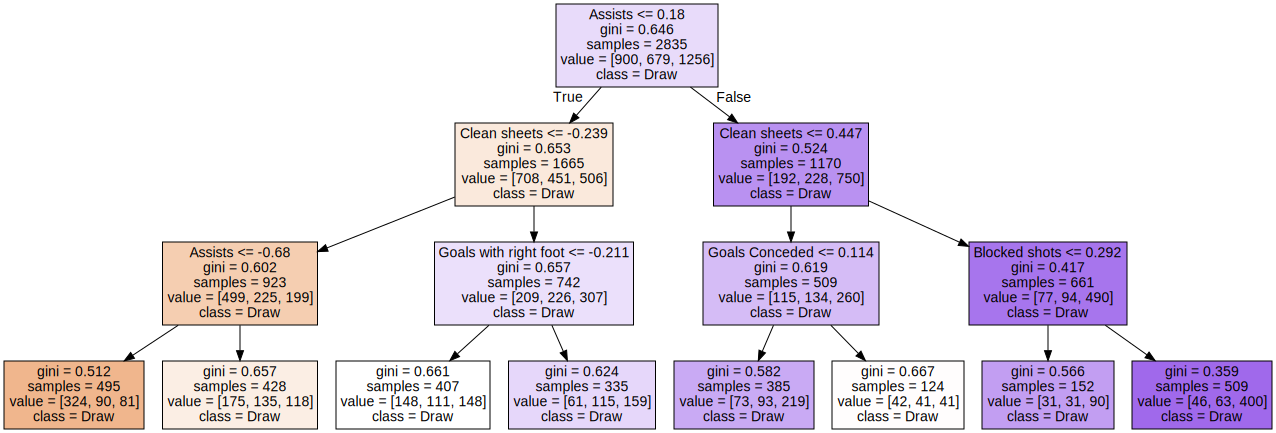

In [60]:
import graphviz
with open("tree.dot") as f:
 dot_graph = f.read()
graphviz.Source(dot_graph)

### optimal parameter for Decision Tree classifier
> max_depth: 3

test score:0.545
val score:0.540

## Random Forest

In [61]:
parameters = {'max_depth':np.arange(1,10)}
RFC = RandomForestClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [62]:
print(clf.best_params_)
print(clf.best_score_)
test_score['RF']=clf.score(X_test,y_test)
val_score['RF']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['RF']))
print("val score:"+str(val_score['RF']))

{'max_depth': 3}
0.5336860670194004
test score:0.5451977401129944
val score:0.5408450704225352


In [63]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['RF']=fin_score

### optimal parameter for Rnadom Forest classifier
> max_depth: 3

test score:0.545
val score:0.540

# Classfication with feature selection

In [75]:
data=pd.read_csv('Data/Dataset.csv').drop(['Unnamed: 0'],axis=1).sort_values(by=['MatchID'])
df_home=data.filter(regex='home').rename(columns=lambda x:x.replace('_home',''))
df_away=data.filter(regex='away').rename(columns=lambda x:x.replace('_away',''))
df_diff=df_home-df_away
cond=[(df_diff['Score']<0),(df_diff['Score']==0),(df_diff['Score']>0)]
val=['Away','Draw','Home']
df_diff['Result']=np.select(cond,val)
df_diff=df_diff.drop(columns=['Score'])
X=df_diff.iloc[:,:-1]
y=df_diff.iloc[:,-1:].values.ravel()

## Feature Selection with Tree

Feature ranking:
1. feature Clean sheets (0.039)
2. feature Assists (0.034)
3. feature Big Chances Created (0.033)
4. feature Passes (0.030)
5. feature Blocked shots (0.030)
6. feature Shots on target (0.026)
7. feature Goals (0.026)
8. feature Goals with right foot (0.024)
9. feature Goals Conceded (0.023)
10. feature Hit woodwork (0.022)
11. feature Tackle success % (0.020)
12. feature Big chances missed (0.020)
13. feature Goals with left foot (0.019)
14. feature Crosses (0.019)
15. feature Catches (0.019)
16. feature Sweeper clearances (0.019)
17. feature Own goals (0.019)
18. feature Clearances off line (0.019)
19. feature Accurate long balls (0.019)
20. feature Shooting accuracy % (0.019)
21. feature Clearances (0.018)
22. feature Through balls (0.018)
23. feature Throw outs (0.018)
24. feature Headed goals (0.018)
25. feature Freekicks scored (0.018)
26. feature Passes per match (0.018)
27. feature Punches (0.018)
28. feature Red cards (0.018)
29. feature Cross accuracy % (0.018

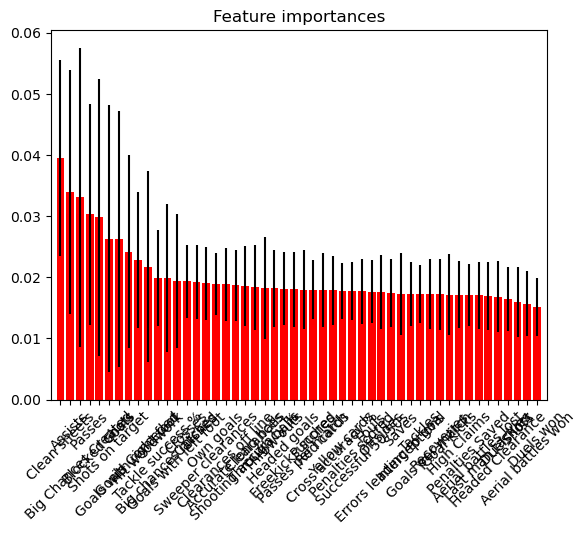

In [76]:
forest=RandomForestClassifier()
forest.fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

In [77]:
X=X.drop(columns=X.columns[indices[12:]])

In [78]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Train,Test,Validation set split
Split train,test,validation set into 0.8,0.1,0.1

In [79]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5)

In [80]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2835, 12), (2835,), (354, 12), (354,), (355, 12), (355,))

## SVM

In [81]:
parameters = {'kernel': ('linear', 'rbf'), 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')})

In [19]:
print(clf.best_params_)
print(clf.best_score_)
test_score['SVM']=clf.score(X_test,y_test)
val_score['SVM']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['SVM']))
print("val score:"+str(val_score['SVM']))

{'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}
0.5534391534391535
test score:0.5706214689265536
val score:0.5690140845070423


In [20]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','C','gamma','kernel']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['SVM']=fin_score

more refine with fixed kernel

In [22]:
parameters = {'kernel': ['rbf'], 'gamma': [0.001,0.0001,0.00001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [0.001, 0.0001, 1e-05], 'kernel': ['rbf']})

In [23]:
print(clf.best_params_)
print(clf.best_score_)
print("test score:"+ str(clf.score(X_test,y_test)))
print("val score:"+str(clf.score(X_val,y_val)))

{'C': 2, 'gamma': 0.001, 'kernel': 'rbf'}
0.5534391534391535
test score:0.5706214689265536
val score:0.5690140845070423


### optimal parameter for SVM classifier
> 'C': 2, 'gamma': 0.001, 'kernel': 'rbf'

test score:0.570
val score:0.569

## SGD classifier

In [53]:
parameters = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],'max_iter':np.arange(500,5000,step=500)}
svc = SGDClassifier()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron',
                                  'squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])})

In [54]:
print(clf.best_params_)
print(clf.best_score_)
test_score['SGD']=clf.score(X_test,y_test)
val_score['SGD']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['SGD']))
print("val score:"+str(val_score['SGD']))

{'loss': 'log_loss', 'max_iter': 3500}
0.5206349206349206
test score:0.5423728813559322
val score:0.532394366197183


In [55]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','loss','max_iter']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['SGD']=fin_score

### optimal parameter for SGD classifier
> 'loss': 'log_loss', 'max_iter': 3500

test score:0.542
val score:0.532

## Decision Tree

In [56]:
parameters = {'max_depth':np.arange(1,10)}
TREE = tree.DecisionTreeClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [57]:
print(clf.best_params_)
print(clf.best_score_)
test_score['DT']=clf.score(X_test,y_test)
val_score['DT']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['DT']))
print("val score:"+str(val_score['DT']))

{'max_depth': 3}
0.5336860670194004
test score:0.5451977401129944
val score:0.5408450704225352


In [58]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['DT']=fin_score

### visualize decision tree

In [59]:
clf=tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="tree.dot", class_names = y_train,
                feature_names = X.columns, impurity=True, filled=True)

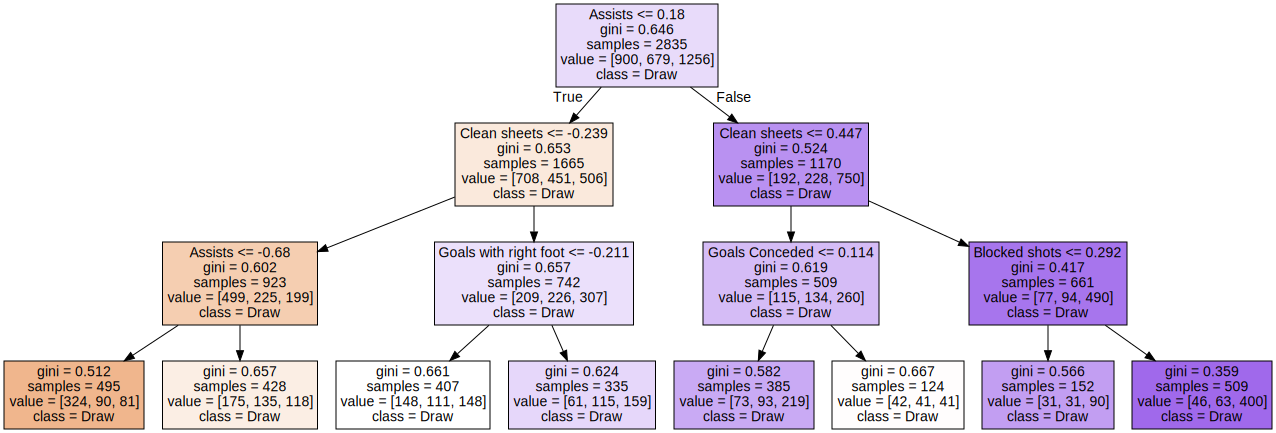

In [60]:
import graphviz
with open("tree.dot") as f:
 dot_graph = f.read()
graphviz.Source(dot_graph)

### optimal parameter for Decision Tree classifier
> max_depth: 3

test score:0.545
val score:0.540

## Random Forest

In [61]:
parameters = {'max_depth':np.arange(1,10)}
RFC = RandomForestClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [62]:
print(clf.best_params_)
print(clf.best_score_)
test_score['RF']=clf.score(X_test,y_test)
val_score['RF']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['RF']))
print("val score:"+str(val_score['RF']))

{'max_depth': 3}
0.5336860670194004
test score:0.5451977401129944
val score:0.5408450704225352


In [63]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['RF']=fin_score

### optimal parameter for Rnadom Forest classifier
> max_depth: 3

test score:0.545
val score:0.540